# Tuning 

- Author: Israel Oliveira [\[e-mail\]](mailto:'Israel%20Oliveira%20'<prof.israel@gmail.com>)

In [1]:
%load_ext watermark

In [2]:
import pandas as pd
import numpy as np
from random_forest_mc.model import RandomForestMC
from random_forest_mc.utils import LoadDicts, dump_file_json, load_file_json
from tqdm.notebook import tqdm
from datetime import datetime
from collections import Counter, defaultdict
from glob import glob
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib 

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
from cycler import cycler

rcParams['figure.figsize'] = 6, 2 # 18, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.grid'] = True
rcParams['axes.prop_cycle'] = cycler(color=['#365977'])
rcParams['lines.linewidth'] = 2.5

In [3]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

In [4]:
import functools
import operator
def flat(a):
    return functools.reduce(operator.iconcat, a, [])

In [5]:
# Run this cell before close.
%watermark -d --iversion -b -r -g -m -v
!cat /proc/cpuinfo |grep 'model name'|head -n 1 |sed -e 's/model\ name/CPU/'
!free -h |cut -d'i' -f1  |grep -v total

Python implementation: CPython
Python version       : 3.11.10
IPython version      : 8.27.0

Compiler    : GCC 10.2.1 20210110
OS          : Linux
Release     : 6.8.0-44-generic
Machine     : x86_64
Processor   : 
CPU cores   : 20
Architecture: 64bit

Git hash: afffba9ffbd19f4c4b696c18f695f73af62368d0

Git repo: https://github.com/ysraell/random-forest-mc-utils.git

Git branch: main

pandas: 2.2.2
numpy : 1.26.4

CPU	: 12th Gen Intel(R) Core(TM) i7-12700
Mem:            15G
Swap:          3.7G


In [6]:
dataset_path = '/work/tmp/credit-card-fraud-prediction'

In [7]:
!ls $dataset_path

model_trans2_tuning_8trees_20240917_1307.json
model_trans_tuning_16trees_20240917_1313.json
model_trans_tuning_16trees_20240917_1353.json
model_trans_tuning_32trees_20240917_1322.json
model_trans_tuning_32trees_20240917_1416.json
model_trans_tuning_8trees_20240917_1339.json
sample_submission.csv
submission_exp1.csv
submission_exp2_trans.csv
submission_exp2_trans_t2.csv
test.csv
test_trans.csv
train.csv
train_trans.csv
trees_metrcis_sim2_20240915_1804.json
trees_metrcis_sim_20240915_1425.json
trees_trans_metrcis_sim2_20240916_1450.json
trees_trans_metrcis_sim_20240916_0327.json


In [128]:
df = pd.read_csv(f'{dataset_path}/train_trans.csv')
#df = df.drop(columns='Time')
target_col = 'IsFraud'
df[target_col] = df[target_col].astype(str)
feat_cols = df.columns.to_list()
feat_cols.remove('id')
feat_cols.remove(target_col)
IsFraud_count, Not_IsFraud_count = df[target_col].value_counts()['1'], df[target_col].value_counts()['0']
IsFraud_count, Not_IsFraud_count

(269, 149731)

In [9]:
split_schema = {
    'test': {
        '1': 10,
        '0': 10000,
    },
    'train': {
        '1': 239,
        '0': 50000,
    },
    'val': {
        '1': 20,
        '0': 6900,
    }
}

In [10]:
df_tmp = df.copy()

dfs = {}
for ds_set in split_schema.keys():
    df_set = pd.concat([
        df_tmp.query(f'{target_col} == "{target_val}"').sample(n=split_schema[ds_set][target_val], random_state=42)
        for target_val in ['1', '0']
    ])
    df_tmp = df_tmp.drop(df_set.index).reset_index(drop=True)
    dfs[ds_set] = df_set.reset_index(drop=True)

df_tofit = pd.concat([dfs['train'], dfs['val']])

In [11]:
df_tmp.shape[0], df_tofit.shape[0], dfs['test'].shape[0], df_tmp.shape[0] + df_tofit.shape[0] + dfs['test'].shape[0]

(82831, 57159, 10010, 150000)

In [113]:
batch_train_pclass = split_schema['train']['1']
batch_val_pclass = split_schema['val']['1']
max_depth = None
n_trees = 256
max_discard_trees = 256
min_feature = 9
max_feature = 10

cpu_cores = 8
max_workers = 16

cls = RandomForestMC(
    n_trees=n_trees, 
    target_col=target_col, 
    max_discard_trees=max_discard_trees,
    batch_train_pclass=batch_train_pclass,
    batch_val_pclass=batch_val_pclass,
    min_feature=min_feature,
    max_feature=max_feature,
    max_depth=max_depth
)
cls

RandomForestMC(len(Forest)=0,n_trees=256,model_version=1.2.0-dev,module_version=1.2.0-dev)

In [114]:
df_test = dfs['test']
y_test = df_test[target_col].astype(int).to_list()
ppy = lambda x: round(100*x, 6)

# Create the model

In [115]:
cls.fitParallel(dataset=df_tofit, max_workers=max_workers)
ModelDict = cls.model2dict()
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
path_dict = f'{dataset_path}/model_tuned_{len(cls)}trees_{datetime_tag}.json'
dump_file_json(path_dict, ModelDict)
del ModelDict

Planting the forest:   0%|          | 0/256 [00:00<?, ?it/s]

In [116]:
cls.setSoftVoting()
y_pred_soft = np.array(cls.testForest(df_test)).astype(int)
accuracy_soft = accuracy_score(y_test, y_pred_soft)
f1_score_soft = f1_score(y_test, y_pred_soft)

print(f"{len(cls)} Trees")
cm = confusion_matrix(y_test, y_pred_soft)
display(pd.DataFrame(cm, columns=['Pred False','Pred True'], index=['False','True']))
tn, fp, fn, tp = cm.ravel()
obj_score = fn / (fn+tp)
print(f"Acc: {ppy(accuracy_soft):.4f}% \n F1: {ppy(f1_score_soft):.4f}% \n FN: {ppy(obj_score):.4f}%")

fc_stars, fc_list = cls.featCount()
print(f"Feat count stats: {fc_stars}")
Counter(fc_list).most_common()

256 Trees


,Pred False,Pred True
False,9830,170
True,6,4


Acc: 98.2418% 
 F1: 4.3478% 
 FN: 60.0000%
Feat count stats: (9.5234375, 0.49945038151326904, 9, 10)


[(10, 134), (9, 122)]

In [ ]:
cls.fitParallel(dataset=df_tofit, max_workers=max_workers)
ModelDict = cls.model2dict()
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
path_dict = f'{dataset_path}/model_trans_tuning_{len(cls)}trees_{datetime_tag}.json'
dump_file_json(path_dict, ModelDict)
del ModelDict

In [ ]:
cls.setSoftVoting()
y_pred_soft = np.array(cls.testForest(df_test)).astype(int)
accuracy_soft = accuracy_score(y_test, y_pred_soft)
f1_score_soft = f1_score(y_test, y_pred_soft)

print(f"{len(cls)} Trees")
cm = confusion_matrix(y_test, y_pred_soft)
display(pd.DataFrame(cm, columns=['Pred False','Pred True'], index=['False','True']))
tn, fp, fn, tp = cm.ravel()
obj_score = fn / (fn+tp)
print(f"Acc: {ppy(accuracy_soft):.4f}% \n F1: {ppy(f1_score_soft):.4f}% \n FN: {ppy(obj_score):.4f}%")

fc_stars, fc_list = cls.featCount()
print(f"Feat count stats: {fc_stars}")
Counter(fc_list).most_common()

In [ ]:
cls.n_trees = 16

In [ ]:
cls.fitParallel(dataset=df_tofit, max_workers=max_workers)
ModelDict = cls.model2dict()
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
path_dict = f'{dataset_path}/model_trans_tuning_{len(cls)}trees_{datetime_tag}.json'
dump_file_json(path_dict, ModelDict)
del ModelDict

In [ ]:
cls.setSoftVoting()
y_pred_soft = np.array(cls.testForest(df_test)).astype(int)
accuracy_soft = accuracy_score(y_test, y_pred_soft)
f1_score_soft = f1_score(y_test, y_pred_soft)

print(f"{len(cls)} Trees")
cm = confusion_matrix(y_test, y_pred_soft)
display(pd.DataFrame(cm, columns=['Pred False','Pred True'], index=['False','True']))
tn, fp, fn, tp = cm.ravel()
obj_score = fn / (fn+tp)
print(f"Acc: {ppy(accuracy_soft):.4f}% \n F1: {ppy(f1_score_soft):.4f}% \n FN: {ppy(obj_score):.4f}%")

fc_stars, fc_list = cls.featCount()
print(f"Feat count stats: {fc_stars}")
Counter(fc_list).most_common()

In [ ]:
cls.n_trees = 256
max_workers = 16

In [ ]:
cls.fitParallel(dataset=df_tofit, max_workers=max_workers)
ModelDict = cls.model2dict()
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
path_dict = f'{dataset_path}/model_trans_tuning_{len(cls)}trees_{datetime_tag}.json'
dump_file_json(path_dict, ModelDict)
del ModelDict

In [ ]:
cls.setSoftVoting()
y_pred_soft = np.array(cls.testForest(df_test)).astype(int)
accuracy_soft = accuracy_score(y_test, y_pred_soft)
f1_score_soft = f1_score(y_test, y_pred_soft)

print(f"{len(cls)} Trees")
cm = confusion_matrix(y_test, y_pred_soft)
display(pd.DataFrame(cm, columns=['Pred False','Pred True'], index=['False','True']))
tn, fp, fn, tp = cm.ravel()
obj_score = fn / (fn+tp)
print(f"Acc: {ppy(accuracy_soft):.4f}% \n F1: {ppy(f1_score_soft):.4f}% \n FN: {ppy(obj_score):.4f}%")

fc_stars, fc_list = cls.featCount()
print(f"Feat count stats: {fc_stars}")
Counter(fc_list).most_common()

# Search for the best set of trees

In [72]:
cls_ = RandomForestMC(target_col=target_col)
cls.process_dataset(df_tofit)

In [73]:
!ls $dataset_path/model_trans_tuning*

/work/tmp/credit-card-fraud-prediction/model_trans_tuning_256trees_20240917_1808.json
/work/tmp/credit-card-fraud-prediction/model_trans_tuning_32trees_20240917_1322.json
/work/tmp/credit-card-fraud-prediction/model_trans_tuning_32trees_20240917_1416.json


In [108]:
model_json = f'{dataset_path}/model_trans_tuning_256trees_20240917_1808.json'
model_dict = load_file_json(model_json)
cls.dict2model(model_dict)
cls

RandomForestMC(len(Forest)=256,n_trees=256,model_version=1.2.0-dev,module_version=1.2.0-dev)

,Depths
count,116796.000000
mean,10.118523
std,0.837048
min,6.000000
25%,10.000000
50%,10.000000
75%,11.000000
max,12.000000


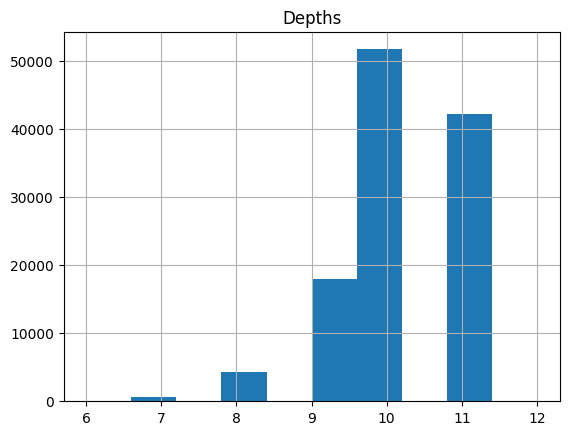

In [16]:
dps = cls.trees2depths
df_dethps = pd.DataFrame(flat(dps), columns=['Depths'])
df_dethps.hist()
df_dethps.describe()

In [17]:
cls_inc = RandomForestMC(target_col=target_col)
cls_inc.process_dataset(df_tofit)
df_frauds = df_test.query(f'{target_col} == "1"').reset_index(drop=True)

tp_soft = []
tp_hard = []
final_N = cls.Forest_size
for i in tqdm(range(1,final_N)):
    cls_inc.reset_forest()
    cls_inc.mergeForest(cls, N=i, by="score")
    cls_inc.setSoftVoting(True)
    y_pred_soft = np.array(cls_inc.testForest(df_frauds)).astype(int)
    tp_soft.append(sum(y_pred_soft))
    cls_inc.setSoftVoting(False)
    y_pred_hard = np.array(cls_inc.testForest(df_frauds)).astype(int)
    tp_hard.append(sum(y_pred_hard))

  0%|          | 0/255 [00:00<?, ?it/s]

,0
count,255.000000
mean,4.827451
std,0.388860
min,4.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,6.000000


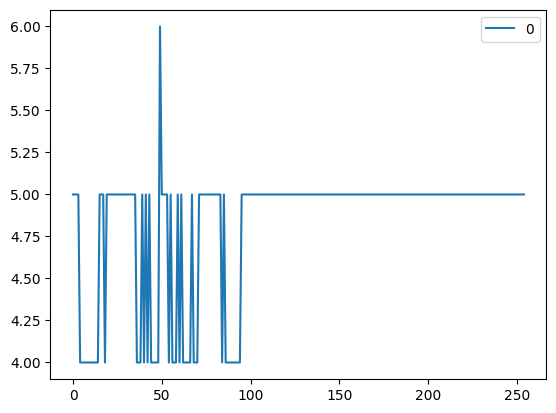

In [18]:
df_soft = pd.DataFrame(tp_soft)
df_soft.plot()
df_soft.describe()

,0
count,255.000000
mean,4.827451
std,0.388860
min,4.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,6.000000


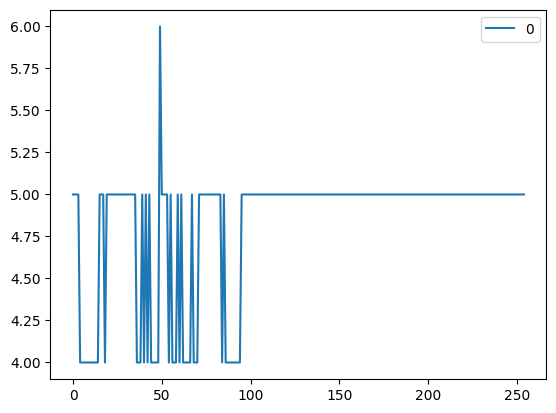

In [19]:
df_hard = pd.DataFrame(tp_hard)
df_hard.plot()
df_hard.describe()

In [20]:
cls_inc = RandomForestMC(target_col=target_col)
cls_inc.process_dataset(df_tofit)
df_frauds = df_test.query(f'{target_col} == "1"').reset_index(drop=True)

tp_soft = []
tp_hard = []
final_N = cls.Forest_size
for i in tqdm(range(1,final_N)):
    cls_inc.reset_forest()
    cls_inc.mergeForest(cls, N=i, by="random")
    cls_inc.setSoftVoting(True)
    y_pred_soft = np.array(cls_inc.testForest(df_frauds)).astype(int)
    tp_soft.append(sum(y_pred_soft))
    cls_inc.setSoftVoting(False)
    y_pred_hard = np.array(cls_inc.testForest(df_frauds)).astype(int)
    tp_hard.append(sum(y_pred_hard))

  0%|          | 0/255 [00:00<?, ?it/s]

,0
count,255.000000
mean,4.909804
std,0.728837
min,2.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,7.000000


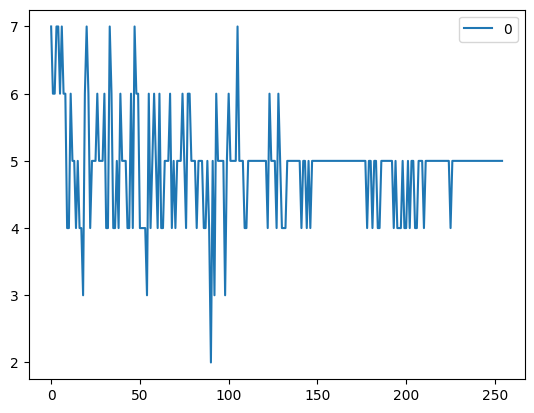

In [21]:
df_soft = pd.DataFrame(tp_soft)
df_soft.plot()
df_soft.describe()

,0
count,255.000000
mean,4.909804
std,0.728837
min,2.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,7.000000


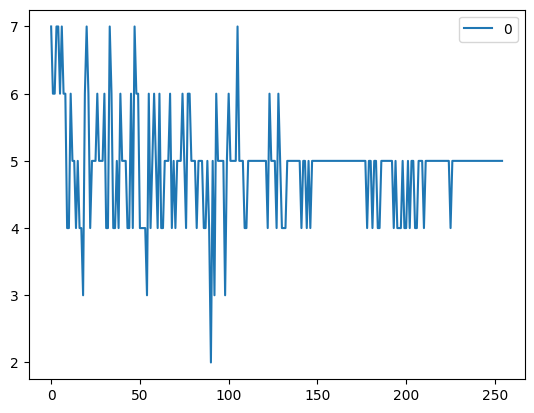

In [22]:
df_hard = pd.DataFrame(tp_hard)
df_hard.plot()
df_hard.describe()

In [23]:
cls_inc = RandomForestMC(target_col=target_col)
cls_inc.process_dataset(df_tofit)
df_frauds = df_test.query(f'{target_col} == "1"').reset_index(drop=True)

N_sim = 100

data = []
final_N = cls.Forest_size
for i in tqdm(range(1,final_N)):
    tp = []
    for _ in range(N_sim):
        cls_inc.reset_forest()
        cls_inc.mergeForest(cls, N=i, by="random")
        cls_inc.setSoftVoting(True)
        y_pred_soft = np.array(cls_inc.testForest(df_frauds)).astype(int)
        tp.append(sum(y_pred_soft))
    data.append(tp)

  0%|          | 0/255 [00:00<?, ?it/s]

<Axes: >

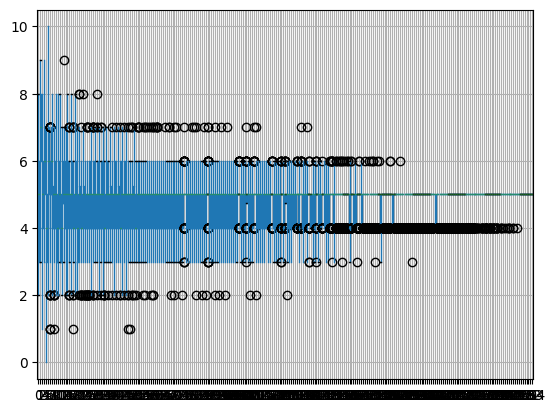

In [26]:
df = pd.DataFrame(data).T

plt.figure()
df.boxplot()

In [27]:
df.describe().T.sort_values(by='mean', ascending=False).head(20)

,count,mean,std,min,25%,50%,75%,max
1,100.0,6.81,1.292519,3.0,6.00,7.0,8.0,9.0
3,100.0,6.21,1.265669,3.0,5.00,6.0,7.0,9.0
5,100.0,5.95,1.320965,2.0,5.00,6.0,7.0,10.0
7,100.0,5.70,1.344649,2.0,5.00,6.0,7.0,8.0
13,100.0,5.27,1.117853,3.0,4.75,5.0,6.0,9.0
11,100.0,5.22,1.251908,3.0,4.00,5.0,6.0,8.0
9,100.0,5.16,1.361223,2.0,4.00,5.0,6.0,8.0
27,100.0,5.09,1.223466,2.0,4.00,5.0,6.0,7.0
17,100.0,5.09,1.164240,2.0,4.00,5.0,6.0,8.0
254,100.0,5.00,0.000000,5.0,5.00,5.0,5.0,5.0


In [28]:
cls_inc = RandomForestMC(target_col=target_col)
cls_inc.process_dataset(df_tofit)
df_frauds = df_test.query(f'{target_col} == "1"').reset_index(drop=True)

N_sim = 1000

data = []
final_N = 10
for i in tqdm(range(1,final_N)):
    tp = []
    for _ in range(N_sim):
        cls_inc.reset_forest()
        cls_inc.mergeForest(cls, N=i, by="random")
        cls_inc.setSoftVoting(True)
        y_pred_soft = np.array(cls_inc.testForest(df_frauds)).astype(int)
        tp.append(sum(y_pred_soft))
    data.append(tp)

  0%|          | 0/9 [00:00<?, ?it/s]

<Axes: >

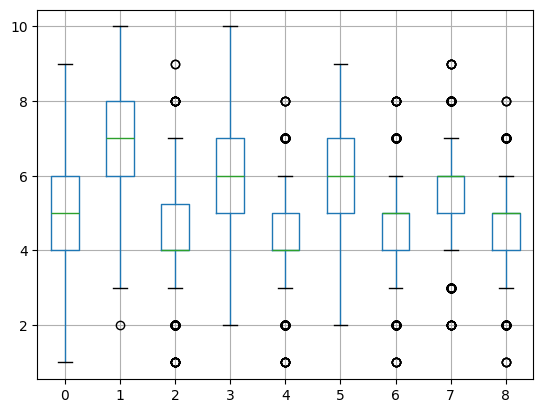

In [29]:
df = pd.DataFrame(data).T

plt.figure()
df.boxplot()

In [31]:
df.describe().T.sort_values(by='mean', ascending=False).head(20)

,count,mean,std,min,25%,50%,75%,max
1,1000.0,6.878,1.359030,2.0,6.0,7.0,8.00,10.0
3,1000.0,6.085,1.381189,2.0,5.0,6.0,7.00,10.0
5,1000.0,5.771,1.291599,2.0,5.0,6.0,7.00,9.0
7,1000.0,5.538,1.275218,2.0,5.0,6.0,6.00,9.0
0,1000.0,4.595,1.526206,1.0,4.0,5.0,6.00,9.0
8,1000.0,4.544,1.240808,1.0,4.0,5.0,5.00,8.0
6,1000.0,4.542,1.334922,1.0,4.0,5.0,5.00,8.0
2,1000.0,4.478,1.430931,1.0,4.0,4.0,5.25,9.0
4,1000.0,4.464,1.356667,1.0,4.0,4.0,5.00,8.0


# Tunning 3 with search 2-4-6-trees

In [120]:
cls.drop_duplicated_trees()

0

In [33]:
cls

RandomForestMC(len(Forest)=256,n_trees=256,model_version=1.2.0-dev,module_version=1.2.0-dev)

In [34]:
cls_inc = RandomForestMC(target_col=target_col)
cls_inc.process_dataset(df_tofit)
cls_inc.setSoftVoting(True)
df_frauds = df_test.query(f'{target_col} == "1"').reset_index(drop=True)
df_notfrauds = df_test.query(f'{target_col} == "0"').sample(n=1000).reset_index(drop=True)
df_mini_test = pd.concat([df_frauds, df_notfrauds], ignore_index=True)
y_test = df_mini_test[target_col].astype(int).to_list()

N_sim = 10000

data = defaultdict(list)
n_trees = [2, 4, 6]
for _ in tqdm(range(N_sim)):
    repated_forest = set()
    for i in n_trees:
        cls_inc.reset_forest()
        cls_inc.mergeForest(cls, N=i, by="random")
        hd5_forest = "".join(sorted([Tree.md5hexdigest for Tree in cls_inc]))
        if hd5_forest in repated_forest:
            continue
        repated_forest.add(hd5_forest)
        y_pred_soft = np.array(cls_inc.testForest(df_mini_test)).astype(int)
        acc = accuracy_score(y_test, y_pred_soft)
        f1 = f1_score(y_test, y_pred_soft)
        miss_rate = sum([not p for t, p in zip(y_test, y_pred_soft) if t]) / sum(y_test)
        for Tree in cls_inc:
            data[Tree.md5hexdigest].append((i, len(Tree.used_features), max(Tree.depths), acc, f1, miss_rate))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [35]:
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
dump_file_json(f"{dataset_path}/trees_trans_metrcis_sim_{datetime_tag}.json", data)

In [36]:
len(data)

256

### Analysing the results

In [ ]:
!ls $dataset_path/trees_metrcis_sim_*.json

In [ ]:
data =  load_file_json('/work/tmp/credit-card-fraud-prediction/trees_metrcis_sim2_*.json')

In [37]:
md5_trees = list(data.keys())

In [38]:
columns = ['Forest Size','Feature Count','Max Depths','Acc','F1','Miss Rate']
list_trees = []
for md5_tree, stats_tree in data.items():
    df_stats = pd.DataFrame(data[md5_tree], columns=columns).max().to_frame().T
    df_stats['Tree'] = md5_tree
    list_trees.append(df_stats)
    df_stats = pd.DataFrame(data[md5_tree], columns=columns).mean().to_frame().T
    df_stats['Tree'] = md5_tree
    list_trees.append(df_stats)

df_trees = pd.concat(list_trees, ignore_index=True)
df_trees

,Forest Size,Feature Count,Max Depths,Acc,F1,Miss Rate,Tree
0,6.000000,5.0,12.0,0.846535,0.095238,0.800000,0ccc172997f8b372e682d1a405151c80
1,4.592593,5.0,12.0,0.729824,0.041810,0.450000,0ccc172997f8b372e682d1a405151c80
2,6.000000,10.0,11.0,0.832673,0.089552,0.700000,b16be8d4c3f4c8ff6400a4c5573d3910
3,4.622407,10.0,11.0,0.732774,0.046046,0.387759,b16be8d4c3f4c8ff6400a4c5573d3910
4,6.000000,10.0,11.0,0.849505,0.096774,0.800000,cc39a541f5bf5dbaf2bf55a16ce1b362
...,...,...,...,...,...,...,...
507,4.702811,4.0,11.0,0.739636,0.048630,0.372289,cf4ee5c5a78724fa2952ea8d7d834076
508,6.000000,9.0,12.0,0.853465,0.097561,0.800000,48b490d8ed71f9694be112398dd5e95b
509,4.665148,9.0,12.0,0.755378,0.049768,0.393394,48b490d8ed71f9694be112398dd5e95b
510,6.000000,4.0,12.0,0.840594,0.094737,0.700000,533b6eacea7366cf702ea2d80335fffe


In [39]:
df_trees.sort_values(by='F1', ascending=False).head(10)

,Forest Size,Feature Count,Max Depths,Acc,F1,Miss Rate,Tree
74,6.0,10.0,11.0,0.864356,0.102273,0.8,7230900758e1d98f4cfc3c0864cfdd6e
122,6.0,3.0,11.0,0.843564,0.102273,0.6,d022586972cc3dc9f22e14539790e651
130,6.0,10.0,11.0,0.843564,0.102273,0.7,2d0d69f16006551aa522b54211ba95b6
452,6.0,10.0,11.0,0.844554,0.102273,0.8,0f05b50baa88ed72a4f5cb6af1040a23
370,6.0,10.0,11.0,0.857426,0.102273,0.8,6e52c50c6b3910b831f037ec5e425f8e
400,6.0,11.0,12.0,0.850495,0.102273,0.7,ac55227cee4980f5418a4facb9a9b49f
14,6.0,10.0,11.0,0.853465,0.100559,0.8,8cb1d9f8b0c7633f05ffc5bf194bade6
158,6.0,10.0,11.0,0.840594,0.100559,0.8,54229f4eece4b6f7ffc49d57641582e7
162,6.0,8.0,11.0,0.851485,0.100559,0.8,4806962a3fe0c3e38bcd51dead459d79
302,6.0,10.0,11.0,0.844554,0.100559,0.7,2e3a4a3fe15946e97ad9879acc5649cc


In [40]:
df_trees.sort_values(by='Miss Rate').head(10)

,Forest Size,Feature Count,Max Depths,Acc,F1,Miss Rate,Tree
295,4.769231,10.0,11.0,0.747298,0.058171,0.255094,e49f22d11177bde7eb74ad25e86551b4
27,4.733607,10.0,11.0,0.743930,0.056775,0.260861,a4073635cb1d71d41c264105a264048f
421,4.653422,10.0,11.0,0.754438,0.059325,0.260927,073400c0f65e111470d3d30db8627089
293,4.493213,10.0,11.0,0.728487,0.053709,0.277828,da0f57a6fa995e74527ddd4c77e5c779
411,4.643629,11.0,12.0,0.744758,0.055840,0.281425,199853f1e4ac7419fb268ee3dfadbd30
395,4.770213,10.0,11.0,0.750038,0.056513,0.283191,b3d35438d2b988334db48db88d77dc95
141,4.834711,10.0,11.0,0.746625,0.055999,0.284091,513003d3fbeda6b46873413cc48a2317
31,4.644880,10.0,11.0,0.740682,0.054878,0.285185,3fd59aae522e6e366a34a52bf220e8de
359,4.596026,10.0,11.0,0.732114,0.052929,0.290066,2f898c0718814ddd27306a075d9e0343
313,4.747515,11.0,12.0,0.746793,0.055763,0.291252,411097085446b27b179dddd5666bf9d1


<Axes: >

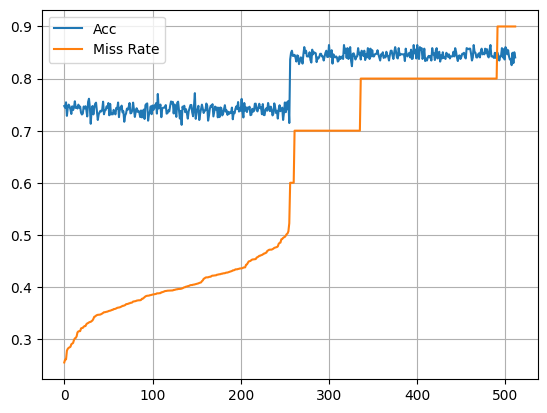

In [41]:
df_trees.sort_values(by='Miss Rate')[['Acc', 'Miss Rate']].reset_index(drop=True).plot(grid=True)

<Axes: >

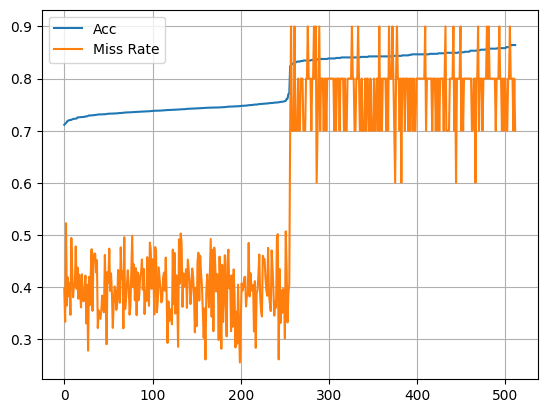

In [42]:
df_trees.sort_values(by='Acc')[['Acc', 'Miss Rate']].reset_index(drop=True).plot(grid=True)

<Axes: >

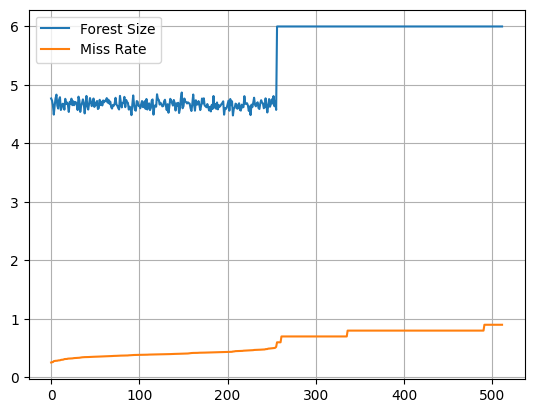

In [43]:
df_trees.sort_values(by='Miss Rate')[['Forest Size', 'Miss Rate']].reset_index(drop=True).plot(grid=True)

<Axes: >

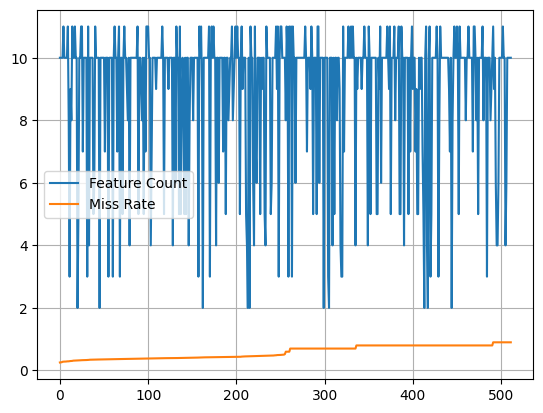

In [44]:
df_trees.sort_values(by='Miss Rate')[['Feature Count', 'Miss Rate']].reset_index(drop=True).plot(grid=True)

In [ ]:
!touch /work/yes.do

# Tuning 3

In [ ]:
batch_train_pclass = split_schema['train']['1']
batch_val_pclass = split_schema['val']['1']
max_depth = 11
n_trees = 256
max_discard_trees = 256
min_feature = 10
max_feature = 10

cpu_cores = 8
max_workers = 2*cpu_cores

cls = RandomForestMC(
    n_trees=n_trees, 
    target_col=target_col, 
    max_discard_trees=max_discard_trees,
    batch_train_pclass=batch_train_pclass,
    batch_val_pclass=batch_val_pclass,
    min_feature=min_feature,
    max_feature=max_feature,
    max_depth=max_depth
)
cls

In [130]:
df_test = dfs['test']
y_test = df_test[target_col].astype(int).to_list()
ppy = lambda x: round(100*x, 6)

In [ ]:
cls.fitParallel(dataset=df_tofit, max_workers=max_workers)
ModelDict = cls.model2dict()
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
path_dict = f'{dataset_path}/model_trans_tuning_{len(cls)}trees_{datetime_tag}.json'
dump_file_json(path_dict, ModelDict)
del ModelDict

In [ ]:
cls.setSoftVoting()
y_pred_soft = np.array(cls.testForest(df_test)).astype(int)
accuracy_soft = accuracy_score(y_test, y_pred_soft)
f1_score_soft = f1_score(y_test, y_pred_soft)

print(f"{len(cls)} Trees")
cm = confusion_matrix(y_test, y_pred_soft)
display(pd.DataFrame(cm, columns=['Pred False','Pred True'], index=['False','True']))
tn, fp, fn, tp = cm.ravel()
obj_score = fn / (fn+tp)
print(f"Acc: {ppy(accuracy_soft):.4f}% \n F1: {ppy(f1_score_soft):.4f}% \n FN: {ppy(obj_score):.4f}%")

fc_stars, fc_list = cls.featCount()
print(f"Feat count stats: {fc_stars}")
Counter(fc_list).most_common()

In [ ]:
cls.drop_duplicated_trees()

In [ ]:
cls

In [131]:
cls_inc = RandomForestMC(target_col=target_col)
cls_inc.process_dataset(df_tofit)
cls_inc.setSoftVoting(True)
df_frauds = df_test.query(f'{target_col} == "1"').reset_index(drop=True)
df_notfrauds = df_test.query(f'{target_col} == "0"').sample(n=1000).reset_index(drop=True)
df_mini_test = pd.concat([df_frauds, df_notfrauds], ignore_index=True)
y_test = df_mini_test[target_col].astype(int).to_list()

N_sim = 10000

data = defaultdict(list)
n_trees = [4, 5, 6]
for _ in tqdm(range(N_sim)):
    repated_forest = set()
    for i in n_trees:
        cls_inc.reset_forest()
        cls_inc.mergeForest(cls, N=i, by="random")
        hd5_forest = "".join(sorted([Tree.md5hexdigest for Tree in cls_inc]))
        if hd5_forest in repated_forest:
            continue
        repated_forest.add(hd5_forest)
        y_pred_soft = np.array(cls_inc.testForest(df_mini_test)).astype(int)
        acc = accuracy_score(y_test, y_pred_soft)
        f1 = f1_score(y_test, y_pred_soft)
        miss_rate = sum([not p for t, p in zip(y_test, y_pred_soft) if t]) / sum(y_test)
        for Tree in cls_inc:
            data[Tree.md5hexdigest].append((i, len(Tree.used_features), max(Tree.depths), acc, f1, miss_rate))

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
dump_file_json(f"{dataset_path}/trees_trans_metrcis_sim3_{datetime_tag}.json", data)

In [ ]:
len(data)

### Analysing the results

In [71]:
!ls $dataset_path/trees_metrcis_sim2_*.json

ls: cannot access '/work/tmp/credit-card-fraud-prediction/trees_metrcis_sim2_*.json': No such file or directory


In [ ]:
data =  load_file_json('/work/tmp/credit-card-fraud-prediction/trees_metrcis_sim2_20240915_1804.json')

In [ ]:
md5_trees = list(data.keys())

In [ ]:
columns = ['Forest Size','Feature Count','Max Depths','Acc','F1','Miss Rate']
list_trees = []
for md5_tree, stats_tree in data.items():
    df_stats = pd.DataFrame(data[md5_tree], columns=columns).max().to_frame().T
    df_stats['Tree'] = md5_tree
    list_trees.append(df_stats)
    df_stats = pd.DataFrame(data[md5_tree], columns=columns).mean().to_frame().T
    df_stats['Tree'] = md5_tree
    list_trees.append(df_stats)

df_trees = pd.concat(list_trees, ignore_index=True)
df_trees

In [49]:
df_trees.sort_values(by='F1', ascending=False).head(10)

,Forest Size,Feature Count,Max Depths,Acc,F1,Miss Rate,Tree
324,6.0,9.0,11.0,0.920792,0.183673,0.8,1e6a288dbfa0ca83808df6694771d80b
354,6.0,10.0,11.0,0.920792,0.183673,0.9,232ce693be42a0de41395b6b6f662e54
110,6.0,10.0,11.0,0.920792,0.183673,0.8,e8ef3fbca3726d4e0d7de93f6bc14255
416,6.0,10.0,11.0,0.920792,0.183673,0.8,74edde510ada9774a2d7091f1fe98900
206,6.0,10.0,11.0,0.920792,0.183673,0.9,e49f22d11177bde7eb74ad25e86551b4
328,6.0,10.0,11.0,0.920792,0.160000,0.8,b52837e949ad9033723523c82f0d68b2
218,6.0,10.0,11.0,0.916832,0.160000,0.8,fdbbc6fb66035f3fdc8d6615cdabc217
76,6.0,10.0,11.0,0.917822,0.160000,0.8,a4073635cb1d71d41c264105a264048f
418,6.0,10.0,11.0,0.916832,0.160000,0.9,489dc639fca81b2ebcddb25a5005c2f4
264,6.0,11.0,12.0,0.916832,0.160000,0.9,f96351008e185e3a4b568b9e255ca67d


In [50]:
df_trees.sort_values(by='Miss Rate').head(10)

,Forest Size,Feature Count,Max Depths,Acc,F1,Miss Rate,Tree
77,5.182741,10.0,11.0,0.818666,0.071290,0.338409,a4073635cb1d71d41c264105a264048f
85,5.116487,10.0,11.0,0.817007,0.071157,0.339247,da0f57a6fa995e74527ddd4c77e5c779
437,5.168367,10.0,11.0,0.825037,0.073457,0.339286,073400c0f65e111470d3d30db8627089
207,5.152753,10.0,11.0,0.826279,0.074166,0.341030,e49f22d11177bde7eb74ad25e86551b4
123,5.141818,11.0,12.0,0.818742,0.070270,0.348545,199853f1e4ac7419fb268ee3dfadbd30
155,5.132404,8.0,11.0,0.810493,0.066502,0.356446,b0eb2833f46d57f43baf7a1b8d1e9f0f
87,5.170984,10.0,11.0,0.807442,0.065075,0.358377,513003d3fbeda6b46873413cc48a2317
101,5.104596,11.0,12.0,0.811318,0.066610,0.358479,411097085446b27b179dddd5666bf9d1
265,5.104348,11.0,12.0,0.821927,0.069355,0.373043,f96351008e185e3a4b568b9e255ca67d
485,5.126582,10.0,11.0,0.823693,0.069657,0.373599,3fd59aae522e6e366a34a52bf220e8de


In [ ]:
df_trees['My Score'] = df_trees['Acc']-2*df_trees['Miss Rate']

In [ ]:
df_trees.sort_values(by='My Score', ascending=False).head(10)

In [93]:
golden_trees = df_trees.sort_values(by='My Score', ascending=False).head(6).Tree.to_list()

In [94]:
cls.data = [Tree for Tree in cls.data if Tree.md5hexdigest in golden_trees]

In [95]:
cls

RandomForestMC(len(Forest)=6,n_trees=256,model_version=1.2.0-dev,module_version=1.2.0-dev)

# Generate the submission file

In [121]:
df_test = pd.read_csv(f'{dataset_path}/test_trans.csv')
df_test

,id,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat20,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,Transaction_Amount
0,150000,-0.729379,-0.418770,-0.122692,0.685474,1.801201,0.317933,-0.537668,-0.492928,0.186811,...,0.419470,-0.530028,0.512478,-0.320477,0.762645,-1.476471,0.662104,-1.984817,-1.955863,0.200614
1,150001,-0.967199,-0.948422,-0.181320,0.471770,1.014431,-1.639838,0.762997,0.125419,0.230368,...,0.758261,0.409252,1.236127,-0.343396,-1.069279,-0.994046,1.393463,1.487245,0.758979,0.040926
2,150002,0.601161,-0.324767,-0.040041,-1.118989,0.905209,-0.571874,-1.012144,-1.847303,0.383486,...,0.804758,1.308602,2.144138,-0.866989,-0.649351,0.403534,0.151693,0.084931,0.255804,1.410986
3,150003,0.809663,-0.281973,-0.714931,-0.105075,1.025281,0.966551,-1.668184,-0.728817,0.816166,...,-0.358853,-0.159244,0.063201,0.091704,-0.797722,0.883891,-0.843995,0.272549,0.067771,-0.406373
4,150004,0.428651,-0.326640,0.440840,-1.026834,0.438053,0.512048,1.317883,-1.434548,0.238628,...,-0.300170,0.067936,0.189630,-0.599081,-0.041038,0.394406,-0.500654,0.022704,0.248110,1.547347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69124,219124,1.624262,-0.104165,0.339478,-1.151265,-3.374176,-1.396422,-0.239808,2.486085,2.122469,...,-0.461286,-0.349678,-0.693283,-0.054359,1.346170,0.240897,-0.208657,-0.314032,-0.373149,1.413336
69125,219125,-0.166251,-0.911678,-0.725224,0.679471,-2.548697,-2.366322,-0.443480,2.302638,-0.972085,...,-0.273539,1.248593,2.710799,-0.104265,-0.212177,-2.520144,1.024263,1.528406,1.679585,0.064907
69126,219126,1.829244,0.335278,-0.614405,-0.150166,-1.629168,0.310995,0.292634,0.137957,-0.594961,...,-0.917303,-0.664766,-1.496607,1.124411,-0.094732,-1.145439,0.517427,-0.500782,-0.369928,-1.204521
69127,219127,1.855195,0.241811,1.024810,-1.857585,-1.497506,-3.179887,0.016132,0.496345,2.912143,...,-0.450039,0.361137,1.081499,1.058779,1.185905,-1.490868,-0.067597,0.169664,-0.204495,0.855445


In [122]:
df_id = df_test['id'].to_frame()
df_test = df_test.drop(columns=['id'])

In [123]:
cls.setSoftVoting()
y_pred_probs = cls.testForestProbs(df_test)

In [124]:
y_pred_soft = [x['1'] for x in y_pred_probs]

In [99]:
!head $dataset_path/sample_submission.csv

id,IsFraud
150000,0.5
150001,0.5
150002,0.5
150003,0.5
150004,0.5
150005,0.5
150006,0.5
150007,0.5
150008,0.5


In [125]:
df_id['IsFraud'] = y_pred_soft
df_id

,id,IsFraud
0,150000,0.257812
1,150001,0.316406
2,150002,0.308594
3,150003,0.343750
4,150004,0.355469
...,...,...
69124,219124,0.222656
69125,219125,0.242188
69126,219126,0.191406
69127,219127,0.246094


In [126]:
df_id.to_csv(f'{dataset_path}/submission_exp2_trans_probs4.csv', index=False)

In [ ]:
!head $dataset_path/submission_exp2_trans_t2.csv

# Kagle results

## Exp1:

Private Score: `0.53218`  (1st: `0.80611`)  
Public Score: `0.59206`  (1st: `0.83947`)  

## Exp2:
Private Score: `0.54502`  
Public score: `0.56385`  